In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from scipy.io import loadmat
from tqdm import tqdm
import multiprocessing as mp
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import PIL.ImageOps as pop
import seaborn as sns
%matplotlib inline

In [3]:
fpX = np.float32
from src.numpy_utility import mosaic_vis, iterate_minibatches
from src.file_utility import save_stuff

In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print "Current dir: %s" % root_dir
print "Time Stamp: %s" % timestamp

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/nsd/
Time Stamp: Apr-18-2020_2146


In [161]:
def applyCropToImg(img, box):
    '''
    applyCropToImg(img, cropBox)
    img ~ any h x w x n image
    cropBox ~ (top, bottom, left, right) in fractions of image size
    '''
    if box[0]+box[1] >= 1:
        raise ValueError('top and bottom crop must sum to less than 1')
    if box[2]+box[3] >= 1:
        raise ValueError('left and right crop must sum to less than 1')
    shape = img.shape
    topCrop = np.round(shape[0]*box[0]).astype(int)
    bottomCrop = np.round(shape[0]*box[1]).astype(int)
    leftCrop = np.round(shape[1]*box[2]).astype(int)
    rightCrop = np.round(shape[1]*box[3]).astype(int)
    croppedImage = img[topCrop:(shape[0]-bottomCrop),leftCrop:(shape[1]-rightCrop)]
    return croppedImage

def maskToIndices(img):
    return img[:,:,0]+img[:,:,1]*256+img[:,:,2]*(256**2)
def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return imgSegIds

def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return np.unique(imgSegIds)
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

def getCategoryNames(catIdToCat, catIds):
    # getCategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['name'] for c in catIds])
def getSupercategoryNames(catIdToCat, catIds):
    # getSupercategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['supercategory'] for c in catIds])

def supercategoryMap(croppedImg, annotations, embbeding):
    # supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    segmentMap = maskToIndices(croppedImg).flatten()
    superMap = np.full(fill_value=-1, shape=segmentMap.shape, dtype=np.int)
    imgSegIds = maskToUniqueIndices(croppedImg)
    catIds = getCategoryIDs(annotations, imgSegIds)
    for c,s in zip(catIds, imgSegIds):
        supercat = getSupercategoryNames(catIdToCat, [c])[0]
        superMap[segmentMap==s] = embbeding[supercat]            
    return superMap.reshape(croppedImg.shape[:2])

## Load a dataset

In [7]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [8]:
exp_design = loadmat(exp_design_file)

In [9]:
print exp_design.keys()

['__globals__', 'masterordering', 'subjectim', 'sharedix', '__header__', 'basiccnt', 'stimpattern', '__version__']


In [10]:
basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

In [10]:
print np.min(trial_order), np.max(trial_order)

1 10000


In [11]:
print "Loading block..."
image_data_set = h5py.File(stim_file', 'r')
print image_data_set.keys()
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print image_data.shape

Loading block...
[u'imgBrick']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


(73000, 425, 425, 3)


In [14]:
print shared_idx.shape
print np.min(shared_idx), np.max(shared_idx)

(1, 1000)
2951 72949


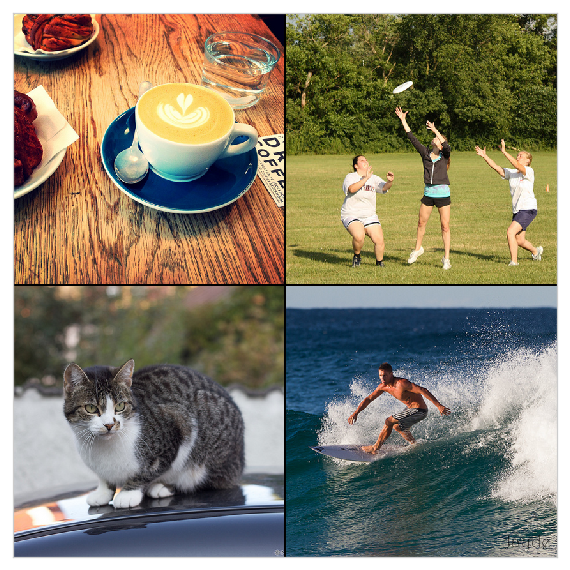

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic_vis(image_data[shared_idx[0,6:10]-1].astype(np.float32), pad=2), cmap='gray', interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

---

# Subject-wise image block
## Native resolution

In [18]:
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1].transpose(0,3,1,2)
    print s_image_data.shape
    save_stuff("%sS%d_stimuli_native"%(stim_root, k+1), {'stimuli': s_image_data})

(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file


## Downsampled resolution

In [16]:
def resize_image_tensor(x, newsize):
    tt = x.transpose((0,2,3,1))
    r  = np.ndarray(shape=x.shape[:1]+newsize+(x.shape[1],), dtype=tt.dtype) 
    for i,t in enumerate(tt):
        r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))
    return r.transpose((0,3,1,2))   

In [17]:
nx = 227
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1]
    s_image_data = resize_image_tensor(s_image_data.transpose(0,3,1,2), newsize=(nx,nx))

    print s_image_data.shape
    save_stuff("%sS%d_stimuli_%d"%(stim_root, k+1, nx), {'stimuli': s_image_data})

(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file


# COCO indices
## Create a block of COCO IDs concordant with the 'subjectim' array 

In [13]:
import pandas as pd
nsd_stiminfo_file = '~/repo.data/datasets/nsd/dev/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)

In [14]:
subject_idx  = exp_design['subjectim']
print subject_idx.shape

cocoId_arr = np.zeros(shape=subject_idx.shape, dtype=int)
crop_arr   = np.zeros(shape=subject_idx.shape+(4,), dtype=np.float32)
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    imageId = subject_idx[j]-1
    for i,k in enumerate(imageId):
        cocoId_arr[j,i] = (cocoId[nsdId==k])[0]
        crop_arr[j,i]   = stiminfo['cropBox'][k]

(8, 10000)


## Reload 

In [17]:
subject = 1

In [18]:
coco_info_set = h5py.File(stim_root + 'nsd_to_coco_indice_map.h5py', 'r')
cocoId_arr = np.copy(coco_info_set['cocoId'])
nsdcrop_arr = np.copy(coco_info_set['crop'])
coco_info_set.close()

print cocoId_arr.shape
print nsdcrop_arr.shape

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print image_data.shape
print image_data.dtype
print np.min(image_data[0]), np.max(image_data[0])

(8, 10000)
(8, 10000, 4)
(10000, 3, 227, 227)
uint8
0 255


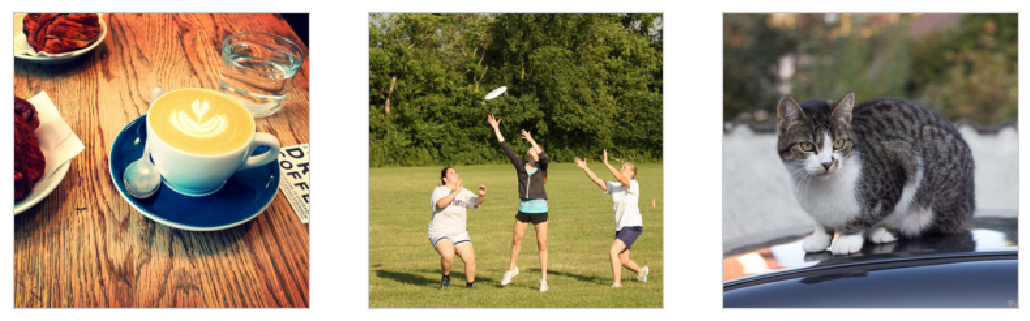

In [19]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [131]:
import json
from collections import defaultdict

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks
panop_trn_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_train2017.json'
panop_val_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_val2017.json'

dataset = dict()
dataset = json.load(open(panop_trn_annFile, 'r'))

imgIdToAnns = defaultdict(list)
catIdToCat = defaultdict(list)
if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)
    for cat in dataset['categories']:
        catIdToCat[cat['id']].append(cat)
        
dataset = dict()
dataset = json.load(open(panop_val_annFile, 'r'))

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

524646
/home/styvesg/repo.data/datasets/coco/panoptic_annotations_trainval2017/annotations/panoptic/000000524646.png
[9, 9, 184, 1, 154, 192, 42, 155, 9, 187]
[u'boat' u'mountain-merged' u'person' u'sand' u'sea' u'sky-other-merged'
 u'surfboard' u'tree-merged']
[u'ground' u'person' u'plant' u'sky' u'solid' u'sports' u'vehicle'
 u'water']


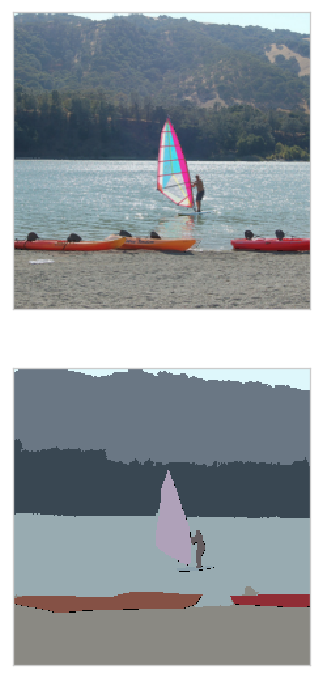

In [111]:
import skimage.io
from skimage.transform import resize

minSize = 227
start_idx = 3
n_idx = 1

plt.figure(figsize=(18,12))
for i in range(n_idx):
    nId = start_idx+i
    cId = cocoId_arr[subject-1, nId]
    print (cId)
    png_name = imgDir + '%012d.png' % cId
    print (png_name)
    crop = nsdcrop_arr[subject-1, nId]
    img = skimage.io.imread(png_name)

    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')

    plt.subplot(2,n_idx,i+1)
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.imshow(croppedImg, alpha=.2)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,n_idx,n_idx+i+1)
    plt.imshow(croppedImg) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ###
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    print (catIds)
    print (getCategoryNames(catIdToCat, catIds))
    print (getSupercategoryNames(catIdToCat, catIds))

In [78]:
stuff_annFile = annDir + 'stuff_annotations_trainval2017/annotations/stuff_train2017.json'
thing_annFile = annDir + 'annotations_trainval2017/annotations/instances_train2017.json'

from pycocotools.coco import COCO
coco_stuff = COCO(stuff_annFile)
coco_thing = COCO(thing_annFile)

loading annotations into memory...
Done (t=23.45s)
creating index...
index created!
loading annotations into memory...
Done (t=18.64s)
creating index...
index created!


In [79]:
# display COCO categories and supercategories
cats = coco_stuff.loadCats(coco_stuff.getCatIds())
stuff_nms=[cat['name'] for cat in cats]
print('COCO stuff categories: \n{}\n'.format(' '.join(stuff_nms)))
super_stuff_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO stuff supercategories: \n{}'.format(' '.join(set(super_stuff_nms))))

print
cats = coco_thing.loadCats(coco_thing.getCatIds())
thing_nms=[cat['name'] for cat in cats]
print('COCO thing categories: \n{}\n'.format(' '.join(thing_nms)))
super_thing_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO thing supercategories: \n{}'.format(' '.join(set(super_thing_nms))))

print 
super_nms = super_thing_nms + super_stuff_nms
print('COCO supercategories: \n{}'.format(' '.join(set(super_nms))))

COCO stuff categories: 
banner blanket branch bridge building-other bush cabinet cage cardboard carpet ceiling-other ceiling-tile cloth clothes clouds counter cupboard curtain desk-stuff dirt door-stuff fence floor-marble floor-other floor-stone floor-tile floor-wood flower fog food-other fruit furniture-other grass gravel ground-other hill house leaves light mat metal mirror-stuff moss mountain mud napkin net paper pavement pillow plant-other plastic platform playingfield railing railroad river road rock roof rug salad sand sea shelf sky-other skyscraper snow solid-other stairs stone straw structural-other table tent textile-other towel tree vegetable wall-brick wall-concrete wall-other wall-panel wall-stone wall-tile wall-wood water-other waterdrops window-blind window-other wood other

COCO stuff supercategories: 
building textile plant floor raw-material sky ceiling water solid window food-stuff furniture-stuff structural other wall ground

COCO thing categories: 
person bicycle ca

In [80]:
print 'super category count = ', len(super_nms)
class_embbeding, label_map = {}, {}
for k,name in enumerate(super_nms):
    class_embbeding[name] = k
    label_map[k] = name 
    print name, ': ', coco_thing.getCatIds(supNms=[name]) + coco_stuff.getCatIds(supNms=[name])

super category count =  28
outdoor :  [10, 11, 13, 14, 15]
food :  [52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
indoor :  [84, 85, 86, 87, 88, 89, 90]
appliance :  [78, 79, 80, 81, 82]
sports :  [34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
person :  [1]
animal :  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
vehicle :  [2, 3, 4, 5, 6, 7, 8, 9]
furniture :  [62, 63, 64, 65, 67, 70]
accessory :  [27, 28, 31, 32, 33]
electronic :  [72, 73, 74, 75, 76, 77]
kitchen :  [44, 46, 47, 48, 49, 50, 51]
building :  [95, 96, 128, 151, 158, 166]
water :  [120, 148, 155, 178, 179]
plant :  [94, 97, 119, 124, 129, 134, 142, 163, 169]
floor :  [101, 114, 115, 116, 117, 118]
raw-material :  [100, 132, 139, 143]
sky :  [106, 157]
ceiling :  [102, 103]
textile :  [92, 93, 104, 105, 109, 131, 137, 141, 152, 167, 168]
solid :  [127, 135, 150, 160, 162, 182]
window :  [180, 181]
food-stuff :  [121, 122, 153, 170]
furniture-stuff :  [98, 107, 108, 110, 112, 123, 130, 133, 156, 161, 165]
ground :  [111, 125, 126, 136, 140,

In [126]:
print (cocoMap[3938])

527257


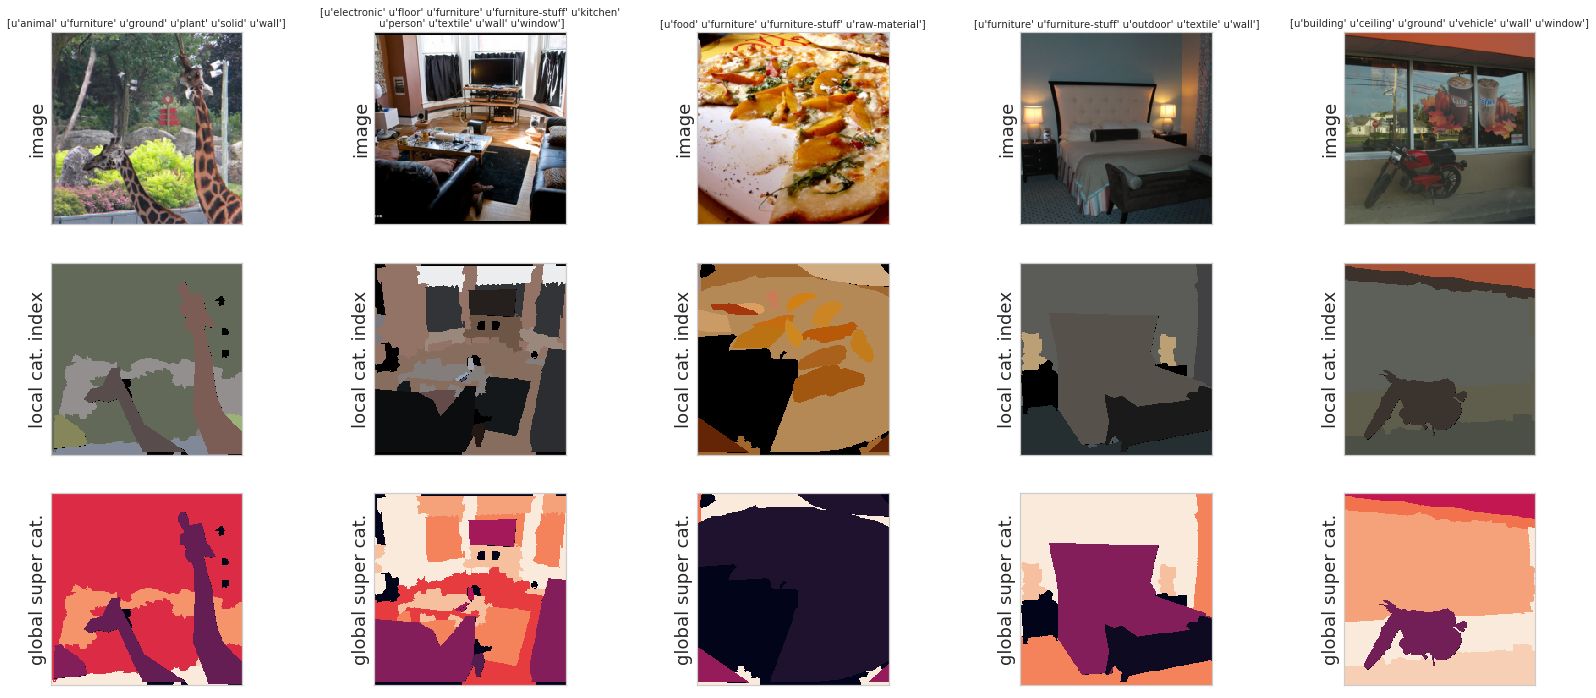

In [128]:
import skimage.io
from skimage.transform import resize
minSize = 227
start_idx = 3938
n_idx = 5

plt.figure(figsize=(28,12))
for i in range(n_idx):
    cId = cocoId_arr[subject-1,start_idx+i]
    png_name = imgDir + '%012d.png' % cId
    crop = nsdcrop_arr[subject-1,start_idx+i]
    img = skimage.io.imread(png_name)
    
    croppedImg = applyCropToImg(img,crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))   
    plt.subplot(3,n_idx,i+1)  
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)    
    plt.ylabel('image')
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,n_idx+i+1)
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,2*n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

In [136]:
cocoMap = np.ones(shape=(73000), dtype=int) * -1
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)] 
    cocoMap[nsdId] = cocoId
print (np.sum(cocoMap==-1))
print (cocoMap.shape)
print (stiminfo['cropBox'].shape)

0
(73000,)
(73000,)


In [159]:
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

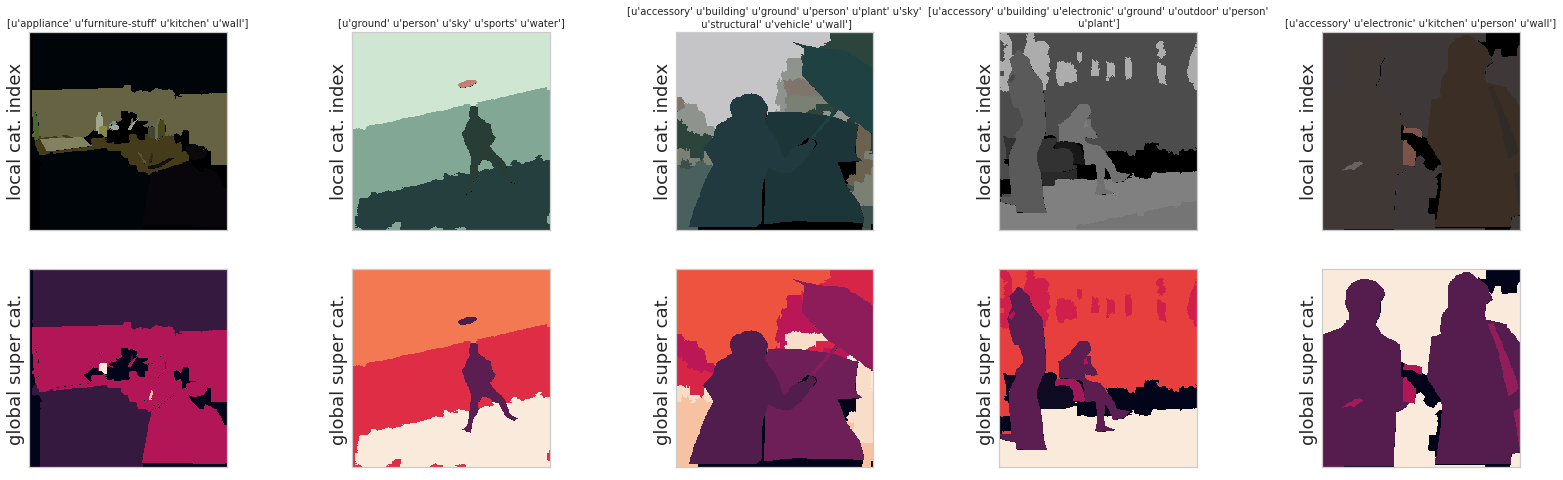

In [160]:
start_idx = 3940
n_idx = 5

plt.figure(figsize=(28,8))
for i,cId in enumerate(cocoMap[start_idx:start_idx+n_idx]):
   
    nId = start_idx + i
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]

    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))
    ###
    plt.subplot(2,n_idx,i+1)
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)  
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(2,n_idx,n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

In [162]:
import skimage.io
from skimage.transform import resize
minSize = 227

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks

cocoCat = {}
for nId,cId in tqdm(enumerate(cocoMap)):
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]
    ##
    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')    
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    ##
    cocoCat[nId] = {}
    cocoCat[nId]['catId'] = catIds
    cocoCat[nId]['catName'] = getCategoryNames(catIdToCat, catIds)
    cocoCat[nId]['supName'] = getSupercategoryNames(catIdToCat, catIds) 


0it [00:00, ?it/s]
7it [00:00, 69.25it/s]
12it [00:00, 60.69it/s]
18it [00:00, 59.63it/s]
24it [00:00, 56.31it/s]
32it [00:00, 60.62it/s]
41it [00:00, 66.96it/s]
53it [00:00, 76.50it/s]
64it [00:00, 82.59it/s]
75it [00:00, 87.46it/s]
86it [00:01, 92.68it/s]
96it [00:01, 89.96it/s]
106it [00:01, 92.48it/s]
116it [00:01, 93.85it/s]
126it [00:01, 92.10it/s]
136it [00:01, 91.25it/s]
147it [00:01, 94.88it/s]
159it [00:01, 99.75it/s]
170it [00:01, 93.64it/s]
180it [00:02, 80.06it/s]
189it [00:02, 77.31it/s]
200it [00:02, 84.48it/s]
212it [00:02, 91.46it/s]
223it [00:02, 94.57it/s]
234it [00:02, 97.73it/s]
245it [00:02, 101.11it/s]
257it [00:02, 103.51it/s]
269it [00:02, 106.44it/s]
280it [00:03, 97.32it/s] 
290it [00:03, 97.01it/s]
301it [00:03, 98.75it/s]
312it [00:03, 99.15it/s]
323it [00:03, 98.01it/s]
333it [00:03, 97.54it/s]
344it [00:03, 99.89it/s]
355it [00:03, 99.42it/s]
366it [00:03, 101.78it/s]
377it [00:04, 100.80it/s]
389it [00:04, 104.56it/s]
400it [00:04, 105.82it/s]
411it [00

3066it [00:30, 112.12it/s]
3078it [00:30, 108.33it/s]
3090it [00:30, 110.28it/s]
3102it [00:30, 108.45it/s]
3113it [00:31, 101.55it/s]
3124it [00:31, 103.08it/s]
3135it [00:31, 104.61it/s]
3147it [00:31, 107.28it/s]
3159it [00:31, 110.65it/s]
3171it [00:31, 110.01it/s]
3183it [00:31, 110.60it/s]
3195it [00:31, 111.15it/s]
3207it [00:31, 111.04it/s]
3219it [00:32, 105.19it/s]
3230it [00:32, 105.78it/s]
3241it [00:32, 102.89it/s]
3252it [00:32, 103.94it/s]
3263it [00:32, 103.53it/s]
3274it [00:32, 90.42it/s] 
3284it [00:32, 91.03it/s]
3294it [00:32, 92.57it/s]
3305it [00:32, 95.07it/s]
3316it [00:33, 98.44it/s]
3328it [00:33, 103.19it/s]
3340it [00:33, 105.91it/s]
3352it [00:33, 107.77it/s]
3363it [00:33, 107.79it/s]
3374it [00:33, 102.59it/s]
3386it [00:33, 107.20it/s]
3399it [00:33, 110.69it/s]
3412it [00:33, 114.89it/s]
3424it [00:34, 115.81it/s]
3436it [00:34, 108.43it/s]
3447it [00:34, 107.81it/s]
3458it [00:34, 103.78it/s]
3469it [00:34, 97.84it/s] 
3479it [00:34, 98.15it/s]
3491it

5147it [01:03, 48.79it/s]
5152it [01:03, 45.73it/s]
5157it [01:03, 45.27it/s]
5163it [01:03, 48.11it/s]
5169it [01:03, 48.87it/s]
5175it [01:04, 50.72it/s]
5181it [01:04, 50.46it/s]
5187it [01:04, 51.36it/s]
5193it [01:04, 50.23it/s]
5199it [01:04, 47.74it/s]
5204it [01:04, 41.93it/s]
5210it [01:04, 45.46it/s]
5216it [01:04, 48.49it/s]
5222it [01:05, 48.15it/s]
5229it [01:05, 51.55it/s]
5235it [01:05, 50.47it/s]
5242it [01:05, 52.87it/s]
5248it [01:05, 47.35it/s]
5253it [01:05, 47.97it/s]
5258it [01:05, 46.60it/s]
5263it [01:05, 45.05it/s]
5268it [01:06, 44.17it/s]
5273it [01:06, 45.05it/s]
5279it [01:06, 47.06it/s]
5284it [01:06, 47.20it/s]
5290it [01:06, 48.67it/s]
5296it [01:06, 50.80it/s]
5302it [01:06, 51.36it/s]
5308it [01:06, 46.73it/s]
5313it [01:06, 46.98it/s]
5319it [01:07, 48.58it/s]
5324it [01:07, 48.57it/s]
5329it [01:07, 47.58it/s]
5335it [01:07, 47.41it/s]
5340it [01:07, 48.04it/s]
5346it [01:07, 49.92it/s]
5352it [01:07, 49.68it/s]
5357it [01:07, 49.00it/s]
5362it [01:0

6717it [01:37, 44.39it/s]
6723it [01:37, 46.45it/s]
6728it [01:37, 46.79it/s]
6734it [01:37, 49.11it/s]
6739it [01:37, 46.23it/s]
6744it [01:37, 45.83it/s]
6750it [01:37, 47.99it/s]
6755it [01:37, 46.42it/s]
6761it [01:38, 47.96it/s]
6766it [01:38, 45.86it/s]
6771it [01:38, 46.63it/s]
6777it [01:38, 48.57it/s]
6783it [01:38, 49.85it/s]
6789it [01:38, 48.92it/s]
6794it [01:38, 44.20it/s]
6799it [01:38, 36.15it/s]
6805it [01:39, 40.92it/s]
6810it [01:39, 41.63it/s]
6815it [01:39, 42.33it/s]
6820it [01:39, 43.73it/s]
6825it [01:39, 43.68it/s]
6830it [01:39, 44.22it/s]
6837it [01:39, 47.69it/s]
6843it [01:39, 50.72it/s]
6849it [01:39, 52.33it/s]
6855it [01:40, 48.02it/s]
6860it [01:40, 44.68it/s]
6866it [01:40, 46.24it/s]
6871it [01:40, 44.23it/s]
6876it [01:40, 43.02it/s]
6882it [01:40, 45.08it/s]
6888it [01:40, 46.96it/s]
6893it [01:40, 46.10it/s]
6898it [01:41, 46.89it/s]
6904it [01:41, 49.26it/s]
6910it [01:41, 51.78it/s]
6917it [01:41, 55.07it/s]
6923it [01:41, 54.90it/s]
6929it [01:4

8332it [02:10, 46.85it/s]
8338it [02:10, 49.69it/s]
8344it [02:10, 49.10it/s]
8350it [02:11, 50.62it/s]
8356it [02:11, 51.14it/s]
8362it [02:11, 48.72it/s]
8368it [02:11, 51.54it/s]
8374it [02:11, 51.13it/s]
8380it [02:11, 51.74it/s]
8386it [02:11, 53.02it/s]
8392it [02:11, 54.00it/s]
8398it [02:11, 54.85it/s]
8404it [02:12, 55.06it/s]
8410it [02:12, 53.90it/s]
8416it [02:12, 49.92it/s]
8422it [02:12, 46.18it/s]
8427it [02:12, 46.99it/s]
8432it [02:12, 46.33it/s]
8437it [02:12, 46.60it/s]
8443it [02:12, 48.40it/s]
8449it [02:13, 50.65it/s]
8455it [02:13, 52.08it/s]
8461it [02:13, 50.39it/s]
8467it [02:13, 50.30it/s]
8473it [02:13, 52.77it/s]
8479it [02:13, 50.55it/s]
8486it [02:13, 54.36it/s]
8494it [02:13, 57.41it/s]
8500it [02:13, 56.16it/s]
8506it [02:14, 55.96it/s]
8512it [02:14, 52.30it/s]
8518it [02:14, 51.42it/s]
8524it [02:14, 51.20it/s]
8530it [02:14, 52.36it/s]
8536it [02:14, 52.35it/s]
8542it [02:14, 54.11it/s]
8548it [02:14, 51.10it/s]
8554it [02:14, 52.59it/s]
8560it [02:1

10010it [02:44, 52.81it/s]
10016it [02:44, 53.32it/s]
10022it [02:44, 52.70it/s]
10028it [02:44, 53.77it/s]
10034it [02:44, 52.21it/s]
10040it [02:44, 51.29it/s]
10046it [02:44, 51.00it/s]
10052it [02:45, 50.03it/s]
10058it [02:45, 51.24it/s]
10065it [02:45, 52.89it/s]
10072it [02:45, 55.97it/s]
10079it [02:45, 57.48it/s]
10085it [02:45, 55.38it/s]
10091it [02:45, 56.61it/s]
10097it [02:45, 55.21it/s]
10103it [02:45, 55.23it/s]
10109it [02:46, 43.07it/s]
10115it [02:46, 46.58it/s]
10121it [02:46, 47.43it/s]
10127it [02:46, 46.68it/s]
10132it [02:46, 46.65it/s]
10138it [02:46, 48.42it/s]
10144it [02:46, 50.00it/s]
10150it [02:46, 46.35it/s]
10157it [02:47, 49.51it/s]
10163it [02:47, 48.20it/s]
10169it [02:47, 48.53it/s]
10174it [02:47, 47.93it/s]
10179it [02:47, 44.90it/s]
10184it [02:47, 44.72it/s]
10189it [02:47, 44.82it/s]
10195it [02:47, 47.71it/s]
10200it [02:48, 47.11it/s]
10207it [02:48, 51.07it/s]
10213it [02:48, 51.26it/s]
10219it [02:48, 51.23it/s]
10225it [02:48, 53.49it/s]
1

11627it [03:16, 41.40it/s]
11632it [03:16, 42.04it/s]
11637it [03:16, 42.24it/s]
11642it [03:17, 42.81it/s]
11647it [03:17, 44.42it/s]
11652it [03:17, 45.37it/s]
11657it [03:17, 45.01it/s]
11663it [03:17, 47.15it/s]
11668it [03:17, 47.38it/s]
11675it [03:17, 50.60it/s]
11681it [03:17, 52.41it/s]
11687it [03:17, 51.98it/s]
11693it [03:18, 49.64it/s]
11699it [03:18, 50.14it/s]
11705it [03:18, 47.58it/s]
11711it [03:18, 49.17it/s]
11716it [03:18, 47.68it/s]
11721it [03:18, 47.45it/s]
11726it [03:18, 46.59it/s]
11731it [03:18, 47.23it/s]
11736it [03:18, 47.38it/s]
11741it [03:19, 48.05it/s]
11747it [03:19, 49.79it/s]
11754it [03:19, 52.88it/s]
11760it [03:19, 50.89it/s]
11766it [03:19, 50.52it/s]
11772it [03:19, 50.87it/s]
11778it [03:19, 52.34it/s]
11785it [03:19, 55.00it/s]
11791it [03:20, 52.28it/s]
11797it [03:20, 53.18it/s]
11803it [03:20, 50.81it/s]
11809it [03:20, 52.94it/s]
11815it [03:20, 54.22it/s]
11821it [03:20, 51.43it/s]
11827it [03:20, 51.20it/s]
11833it [03:20, 52.58it/s]
1

13244it [03:48, 52.00it/s]
13250it [03:49, 50.03it/s]
13256it [03:49, 49.89it/s]
13262it [03:49, 51.73it/s]
13268it [03:49, 52.67it/s]
13274it [03:49, 52.28it/s]
13281it [03:49, 55.18it/s]
13287it [03:49, 55.40it/s]
13293it [03:49, 55.31it/s]
13299it [03:49, 53.85it/s]
13305it [03:50, 52.95it/s]
13311it [03:50, 51.50it/s]
13317it [03:50, 52.92it/s]
13323it [03:50, 53.51it/s]
13329it [03:50, 51.96it/s]
13335it [03:50, 53.20it/s]
13342it [03:50, 54.08it/s]
13348it [03:50, 54.62it/s]
13354it [03:50, 51.79it/s]
13360it [03:51, 52.46it/s]
13366it [03:51, 53.18it/s]
13372it [03:51, 52.73it/s]
13378it [03:51, 54.66it/s]
13384it [03:51, 52.42it/s]
13390it [03:51, 53.15it/s]
13396it [03:51, 55.01it/s]
13402it [03:51, 55.16it/s]
13408it [03:51, 55.69it/s]
13414it [03:52, 55.85it/s]
13420it [03:52, 52.60it/s]
13426it [03:52, 48.69it/s]
13433it [03:52, 52.62it/s]
13440it [03:52, 55.29it/s]
13446it [03:52, 55.80it/s]
13452it [03:52, 55.27it/s]
13458it [03:52, 54.56it/s]
13464it [03:52, 55.32it/s]
1

14929it [04:20, 51.93it/s]
14935it [04:20, 52.90it/s]
14941it [04:21, 53.24it/s]
14947it [04:21, 53.95it/s]
14953it [04:21, 55.23it/s]
14959it [04:21, 54.85it/s]
14965it [04:21, 54.26it/s]
14972it [04:21, 55.47it/s]
14978it [04:21, 53.75it/s]
14985it [04:21, 55.86it/s]
14991it [04:22, 55.80it/s]
14997it [04:22, 52.39it/s]
15003it [04:22, 48.88it/s]
15008it [04:22, 45.85it/s]
15013it [04:22, 46.11it/s]
15018it [04:22, 46.88it/s]
15023it [04:22, 37.67it/s]
15029it [04:22, 41.33it/s]
15034it [04:23, 41.87it/s]
15039it [04:23, 42.96it/s]
15044it [04:23, 44.47it/s]
15050it [04:23, 46.81it/s]
15056it [04:23, 49.31it/s]
15062it [04:23, 50.04it/s]
15068it [04:23, 52.34it/s]
15074it [04:23, 51.77it/s]
15080it [04:23, 51.17it/s]
15086it [04:24, 52.57it/s]
15093it [04:24, 54.20it/s]
15100it [04:24, 55.97it/s]
15106it [04:24, 55.27it/s]
15112it [04:24, 54.82it/s]
15118it [04:24, 52.35it/s]
15124it [04:24, 51.59it/s]
15130it [04:24, 51.94it/s]
15136it [04:24, 52.00it/s]
15142it [04:25, 51.13it/s]
1

16568it [04:52, 50.94it/s]
16574it [04:52, 52.49it/s]
16581it [04:53, 54.60it/s]
16587it [04:53, 42.87it/s]
16593it [04:53, 45.11it/s]
16600it [04:53, 49.06it/s]
16606it [04:53, 51.43it/s]
16612it [04:53, 49.99it/s]
16618it [04:53, 49.09it/s]
16624it [04:53, 48.37it/s]
16630it [04:54, 50.57it/s]
16637it [04:54, 52.68it/s]
16643it [04:54, 53.59it/s]
16649it [04:54, 53.88it/s]
16655it [04:54, 53.78it/s]
16661it [04:54, 52.88it/s]
16667it [04:54, 54.52it/s]
16673it [04:54, 55.77it/s]
16679it [04:54, 56.03it/s]
16685it [04:55, 55.70it/s]
16691it [04:55, 48.46it/s]
16697it [04:55, 48.86it/s]
16703it [04:55, 50.69it/s]
16710it [04:55, 54.11it/s]
16716it [04:55, 52.16it/s]
16722it [04:55, 52.89it/s]
16728it [04:55, 52.08it/s]
16734it [04:56, 53.58it/s]
16740it [04:56, 54.65it/s]
16748it [04:56, 57.45it/s]
16754it [04:56, 55.04it/s]
16761it [04:56, 57.36it/s]
16767it [04:56, 55.79it/s]
16773it [04:56, 55.75it/s]
16779it [04:56, 56.09it/s]
16785it [04:56, 56.41it/s]
16792it [04:57, 57.41it/s]
1

18243it [05:25, 48.87it/s]
18248it [05:25, 48.75it/s]
18254it [05:25, 47.92it/s]
18260it [05:25, 49.87it/s]
18266it [05:25, 50.76it/s]
18272it [05:25, 50.47it/s]
18278it [05:25, 51.62it/s]
18284it [05:25, 53.01it/s]
18290it [05:26, 54.65it/s]
18296it [05:26, 55.03it/s]
18302it [05:26, 51.99it/s]
18308it [05:26, 50.17it/s]
18314it [05:26, 51.66it/s]
18320it [05:26, 53.01it/s]
18327it [05:26, 56.73it/s]
18333it [05:26, 55.26it/s]
18339it [05:26, 55.01it/s]
18346it [05:27, 55.93it/s]
18352it [05:27, 52.21it/s]
18358it [05:27, 52.93it/s]
18364it [05:27, 53.01it/s]
18370it [05:27, 51.43it/s]
18377it [05:27, 53.82it/s]
18383it [05:27, 54.24it/s]
18390it [05:27, 56.32it/s]
18396it [05:28, 56.07it/s]
18402it [05:28, 52.97it/s]
18408it [05:28, 50.00it/s]
18415it [05:28, 52.74it/s]
18421it [05:28, 50.40it/s]
18427it [05:28, 51.36it/s]
18433it [05:28, 49.79it/s]
18439it [05:28, 43.75it/s]
18445it [05:29, 47.43it/s]
18451it [05:29, 48.03it/s]
18456it [05:29, 47.09it/s]
18463it [05:29, 49.97it/s]
1

19903it [05:57, 56.91it/s]
19909it [05:57, 56.21it/s]
19916it [05:57, 58.50it/s]
19922it [05:57, 58.71it/s]
19929it [05:57, 58.73it/s]
19935it [05:57, 56.47it/s]
19941it [05:58, 55.20it/s]
19947it [05:58, 51.21it/s]
19953it [05:58, 53.03it/s]
19959it [05:58, 53.46it/s]
19965it [05:58, 51.81it/s]
19971it [05:58, 51.30it/s]
19977it [05:58, 51.09it/s]
19983it [05:58, 51.73it/s]
19989it [05:59, 50.74it/s]
19995it [05:59, 39.43it/s]
20001it [05:59, 43.88it/s]
20006it [05:59, 43.78it/s]
20011it [05:59, 38.66it/s]
20016it [05:59, 37.54it/s]
20023it [05:59, 43.53it/s]
20029it [06:00, 45.59it/s]
20035it [06:00, 48.83it/s]
20041it [06:00, 50.43it/s]
20049it [06:00, 54.88it/s]
20055it [06:00, 53.87it/s]
20061it [06:00, 54.28it/s]
20067it [06:00, 52.83it/s]
20073it [06:00, 53.02it/s]
20079it [06:00, 53.36it/s]
20085it [06:01, 49.31it/s]
20091it [06:01, 47.86it/s]
20097it [06:01, 49.79it/s]
20103it [06:01, 52.37it/s]
20109it [06:01, 51.77it/s]
20115it [06:01, 51.48it/s]
20121it [06:01, 53.47it/s]
2

21555it [06:30, 41.59it/s]
21560it [06:30, 42.99it/s]
21565it [06:30, 43.11it/s]
21570it [06:30, 44.21it/s]
21576it [06:30, 47.51it/s]
21582it [06:30, 48.74it/s]
21588it [06:30, 51.51it/s]
21594it [06:30, 52.52it/s]
21600it [06:30, 54.19it/s]
21606it [06:30, 53.21it/s]
21612it [06:31, 54.44it/s]
21618it [06:31, 54.45it/s]
21624it [06:31, 55.59it/s]
21630it [06:31, 55.25it/s]
21636it [06:31, 53.40it/s]
21642it [06:31, 53.44it/s]
21648it [06:31, 52.72it/s]
21654it [06:31, 53.18it/s]
21660it [06:31, 54.83it/s]
21666it [06:32, 55.80it/s]
21672it [06:32, 54.10it/s]
21678it [06:32, 52.93it/s]
21684it [06:32, 51.18it/s]
21690it [06:32, 47.70it/s]
21696it [06:32, 49.74it/s]
21702it [06:32, 50.61it/s]
21709it [06:32, 53.97it/s]
21716it [06:33, 56.39it/s]
21722it [06:33, 56.52it/s]
21728it [06:33, 52.27it/s]
21734it [06:33, 52.20it/s]
21740it [06:33, 50.25it/s]
21746it [06:33, 52.47it/s]
21752it [06:33, 53.42it/s]
21758it [06:33, 54.01it/s]
21764it [06:33, 52.75it/s]
21771it [06:34, 55.91it/s]
2

23215it [07:02, 51.63it/s]
23222it [07:02, 53.46it/s]
23228it [07:02, 54.69it/s]
23234it [07:02, 55.10it/s]
23240it [07:02, 54.54it/s]
23246it [07:03, 54.48it/s]
23252it [07:03, 55.66it/s]
23258it [07:03, 55.23it/s]
23264it [07:03, 51.60it/s]
23270it [07:03, 51.80it/s]
23276it [07:03, 51.94it/s]
23283it [07:03, 55.03it/s]
23289it [07:03, 53.86it/s]
23295it [07:03, 54.24it/s]
23301it [07:04, 53.97it/s]
23307it [07:04, 54.72it/s]
23313it [07:04, 54.24it/s]
23320it [07:04, 54.29it/s]
23326it [07:04, 52.07it/s]
23332it [07:04, 53.76it/s]
23338it [07:04, 50.36it/s]
23344it [07:04, 51.80it/s]
23350it [07:05, 49.95it/s]
23356it [07:05, 50.95it/s]
23362it [07:05, 45.44it/s]
23368it [07:05, 47.61it/s]
23374it [07:05, 50.30it/s]
23381it [07:05, 54.87it/s]
23387it [07:05, 54.28it/s]
23393it [07:05, 52.11it/s]
23399it [07:05, 51.14it/s]
23405it [07:06, 50.96it/s]
23411it [07:06, 51.77it/s]
23418it [07:06, 54.14it/s]
23425it [07:06, 56.48it/s]
23431it [07:06, 55.68it/s]
23438it [07:06, 57.24it/s]
2

24896it [07:34, 56.52it/s]
24902it [07:34, 55.40it/s]
24908it [07:34, 53.37it/s]
24915it [07:34, 56.54it/s]
24921it [07:34, 57.53it/s]
24927it [07:35, 54.93it/s]
24933it [07:35, 54.84it/s]
24939it [07:35, 53.26it/s]
24946it [07:35, 54.63it/s]
24952it [07:35, 54.77it/s]
24959it [07:35, 56.47it/s]
24965it [07:35, 41.86it/s]
24970it [07:35, 40.43it/s]
24977it [07:36, 44.35it/s]
24982it [07:36, 44.67it/s]
24989it [07:36, 47.73it/s]
24996it [07:36, 51.32it/s]
25002it [07:36, 51.38it/s]
25008it [07:36, 51.76it/s]
25014it [07:36, 52.91it/s]
25021it [07:36, 56.13it/s]
25027it [07:36, 57.12it/s]
25033it [07:37, 55.53it/s]
25039it [07:37, 56.59it/s]
25046it [07:37, 57.50it/s]
25052it [07:37, 56.25it/s]
25058it [07:37, 54.70it/s]
25064it [07:37, 53.07it/s]
25071it [07:37, 56.55it/s]
25078it [07:37, 58.06it/s]
25084it [07:37, 57.24it/s]
25092it [07:38, 61.00it/s]
25099it [07:38, 57.55it/s]
25106it [07:38, 59.00it/s]
25112it [07:38, 55.66it/s]
25118it [07:38, 55.10it/s]
25124it [07:38, 53.54it/s]
2

26570it [08:06, 46.21it/s]
26576it [08:06, 47.63it/s]
26582it [08:06, 49.29it/s]
26588it [08:07, 48.89it/s]
26594it [08:07, 50.33it/s]
26600it [08:07, 52.76it/s]
26607it [08:07, 55.68it/s]
26614it [08:07, 57.49it/s]
26620it [08:07, 54.62it/s]
26626it [08:07, 55.42it/s]
26632it [08:07, 54.61it/s]
26638it [08:07, 53.14it/s]
26644it [08:08, 50.81it/s]
26651it [08:08, 52.41it/s]
26657it [08:08, 52.08it/s]
26663it [08:08, 48.53it/s]
26669it [08:08, 49.66it/s]
26675it [08:08, 48.54it/s]
26680it [08:08, 48.19it/s]
26685it [08:08, 47.30it/s]
26690it [08:08, 47.53it/s]
26696it [08:09, 49.20it/s]
26702it [08:09, 49.16it/s]
26707it [08:09, 49.08it/s]
26712it [08:09, 48.34it/s]
26717it [08:09, 48.56it/s]
26722it [08:09, 44.62it/s]
26728it [08:09, 47.67it/s]
26733it [08:09, 48.24it/s]
26739it [08:09, 48.72it/s]
26746it [08:10, 52.50it/s]
26752it [08:10, 52.52it/s]
26759it [08:10, 56.07it/s]
26765it [08:10, 52.95it/s]
26771it [08:10, 49.39it/s]
26777it [08:10, 46.77it/s]
26782it [08:10, 45.55it/s]
2

28207it [08:39, 52.82it/s]
28213it [08:39, 51.97it/s]
28219it [08:39, 52.43it/s]
28225it [08:39, 51.73it/s]
28232it [08:39, 55.25it/s]
28238it [08:40, 53.24it/s]
28244it [08:40, 54.38it/s]
28250it [08:40, 53.39it/s]
28256it [08:40, 52.52it/s]
28262it [08:40, 53.25it/s]
28269it [08:40, 56.50it/s]
28275it [08:40, 54.15it/s]
28281it [08:40, 54.40it/s]
28287it [08:40, 54.41it/s]
28293it [08:41, 53.80it/s]
28299it [08:41, 54.00it/s]
28305it [08:41, 52.73it/s]
28312it [08:41, 55.28it/s]
28318it [08:41, 54.57it/s]
28325it [08:41, 55.16it/s]
28331it [08:41, 43.53it/s]
28336it [08:41, 45.07it/s]
28342it [08:42, 47.08it/s]
28347it [08:42, 43.90it/s]
28352it [08:42, 42.93it/s]
28357it [08:42, 44.35it/s]
28362it [08:42, 44.03it/s]
28368it [08:42, 47.37it/s]
28374it [08:42, 49.29it/s]
28380it [08:42, 49.42it/s]
28386it [08:42, 51.05it/s]
28393it [08:43, 53.01it/s]
28399it [08:43, 51.14it/s]
28405it [08:43, 51.82it/s]
28412it [08:43, 53.49it/s]
28418it [08:43, 52.09it/s]
28425it [08:43, 54.37it/s]
2

29893it [09:11, 39.80it/s]
29899it [09:12, 43.14it/s]
29904it [09:12, 42.89it/s]
29909it [09:12, 29.83it/s]
29914it [09:12, 33.81it/s]
29919it [09:12, 35.16it/s]
29925it [09:12, 39.23it/s]
29932it [09:12, 44.39it/s]
29939it [09:13, 48.56it/s]
29945it [09:13, 50.23it/s]
29951it [09:13, 51.05it/s]
29957it [09:13, 51.22it/s]
29963it [09:13, 50.60it/s]
29969it [09:13, 49.99it/s]
29976it [09:13, 53.45it/s]
29982it [09:13, 54.73it/s]
29988it [09:13, 55.52it/s]
29994it [09:14, 54.14it/s]
30000it [09:14, 55.41it/s]
30006it [09:14, 56.54it/s]
30012it [09:14, 56.41it/s]
30019it [09:14, 58.17it/s]
30025it [09:14, 57.55it/s]
30031it [09:14, 54.60it/s]
30037it [09:14, 53.51it/s]
30043it [09:14, 54.86it/s]
30050it [09:15, 56.28it/s]
30056it [09:15, 54.74it/s]
30062it [09:15, 53.63it/s]
30068it [09:15, 54.72it/s]
30074it [09:15, 49.95it/s]
30080it [09:15, 52.16it/s]
30087it [09:15, 54.44it/s]
30093it [09:15, 55.43it/s]
30100it [09:15, 56.13it/s]
30106it [09:16, 54.03it/s]
30112it [09:16, 52.59it/s]
3

31558it [09:44, 43.02it/s]
31563it [09:44, 38.11it/s]
31568it [09:44, 37.44it/s]
31573it [09:44, 40.40it/s]
31579it [09:44, 42.63it/s]
31586it [09:45, 47.43it/s]
31592it [09:45, 49.37it/s]
31598it [09:45, 49.76it/s]
31604it [09:45, 50.35it/s]
31610it [09:45, 50.56it/s]
31616it [09:45, 46.10it/s]
31623it [09:45, 49.78it/s]
31629it [09:45, 48.51it/s]
31635it [09:46, 49.23it/s]
31642it [09:46, 52.85it/s]
31648it [09:46, 49.45it/s]
31654it [09:46, 49.83it/s]
31660it [09:46, 49.25it/s]
31667it [09:46, 52.52it/s]
31674it [09:46, 55.07it/s]
31680it [09:46, 52.49it/s]
31687it [09:46, 54.38it/s]
31693it [09:47, 55.69it/s]
31699it [09:47, 55.45it/s]
31705it [09:47, 54.56it/s]
31711it [09:47, 51.50it/s]
31717it [09:47, 52.56it/s]
31723it [09:47, 53.08it/s]
31729it [09:47, 48.14it/s]
31734it [09:47, 46.04it/s]
31741it [09:48, 50.61it/s]
31747it [09:48, 48.62it/s]
31753it [09:48, 51.14it/s]
31760it [09:48, 55.15it/s]
31766it [09:48, 53.25it/s]
31772it [09:48, 52.21it/s]
31778it [09:48, 52.90it/s]
3

33204it [10:16, 52.05it/s]
33211it [10:16, 54.46it/s]
33217it [10:16, 51.35it/s]
33223it [10:17, 41.37it/s]
33228it [10:17, 41.83it/s]
33234it [10:17, 45.66it/s]
33240it [10:17, 47.60it/s]
33245it [10:17, 47.76it/s]
33250it [10:17, 48.21it/s]
33255it [10:17, 47.97it/s]
33260it [10:17, 47.84it/s]
33267it [10:17, 51.99it/s]
33273it [10:18, 49.97it/s]
33279it [10:18, 39.80it/s]
33286it [10:18, 45.08it/s]
33292it [10:18, 45.03it/s]
33297it [10:18, 45.95it/s]
33303it [10:18, 48.00it/s]
33309it [10:18, 47.95it/s]
33315it [10:18, 49.15it/s]
33321it [10:19, 47.01it/s]
33326it [10:19, 46.95it/s]
33332it [10:19, 50.03it/s]
33339it [10:19, 53.77it/s]
33345it [10:19, 52.43it/s]
33351it [10:19, 53.89it/s]
33357it [10:19, 54.67it/s]
33364it [10:19, 56.56it/s]
33370it [10:19, 57.45it/s]
33376it [10:20, 55.54it/s]
33383it [10:20, 57.46it/s]
33389it [10:20, 56.59it/s]
33395it [10:20, 56.28it/s]
33401it [10:20, 55.65it/s]
33407it [10:20, 53.86it/s]
33413it [10:20, 55.25it/s]
33419it [10:20, 54.77it/s]
3

34877it [10:48, 52.27it/s]
34883it [10:48, 48.30it/s]
34888it [10:48, 43.96it/s]
34894it [10:48, 45.84it/s]
34900it [10:48, 48.64it/s]
34907it [10:48, 52.93it/s]
34913it [10:49, 51.53it/s]
34919it [10:49, 50.45it/s]
34926it [10:49, 53.45it/s]
34933it [10:49, 56.78it/s]
34939it [10:49, 53.42it/s]
34945it [10:49, 53.91it/s]
34951it [10:49, 51.37it/s]
34957it [10:49, 51.70it/s]
34963it [10:50, 51.77it/s]
34969it [10:50, 53.12it/s]
34975it [10:50, 49.21it/s]
34981it [10:50, 50.25it/s]
34987it [10:50, 49.31it/s]
34993it [10:50, 50.69it/s]
35000it [10:50, 53.12it/s]
35006it [10:50, 47.19it/s]
35011it [10:51, 36.69it/s]
35016it [10:51, 31.25it/s]
35020it [10:51, 31.61it/s]
35027it [10:51, 34.06it/s]
35032it [10:51, 37.00it/s]
35036it [10:51, 35.14it/s]
35042it [10:51, 39.74it/s]
35047it [10:52, 37.83it/s]
35052it [10:52, 36.66it/s]
35059it [10:52, 42.00it/s]
35065it [10:52, 45.55it/s]
35071it [10:52, 46.56it/s]
35076it [10:52, 43.24it/s]
35082it [10:52, 45.14it/s]
35088it [10:52, 47.57it/s]
3

36551it [11:20, 54.99it/s]
36558it [11:21, 57.38it/s]
36566it [11:21, 60.46it/s]
36573it [11:21, 58.02it/s]
36579it [11:21, 54.15it/s]
36585it [11:21, 52.44it/s]
36591it [11:21, 51.14it/s]
36597it [11:21, 49.95it/s]
36604it [11:21, 52.23it/s]
36610it [11:22, 52.35it/s]
36616it [11:22, 52.44it/s]
36622it [11:22, 50.28it/s]
36629it [11:22, 52.87it/s]
36635it [11:22, 52.18it/s]
36641it [11:22, 52.04it/s]
36647it [11:22, 53.83it/s]
36653it [11:22, 54.04it/s]
36659it [11:23, 54.41it/s]
36665it [11:23, 52.32it/s]
36671it [11:23, 52.85it/s]
36677it [11:23, 51.19it/s]
36683it [11:23, 51.32it/s]
36689it [11:23, 53.05it/s]
36695it [11:23, 51.32it/s]
36701it [11:23, 53.17it/s]
36707it [11:23, 54.25it/s]
36714it [11:24, 54.97it/s]
36720it [11:24, 45.74it/s]
36726it [11:24, 48.04it/s]
36732it [11:24, 48.88it/s]
36738it [11:24, 49.46it/s]
36745it [11:24, 53.87it/s]
36752it [11:24, 56.05it/s]
36758it [11:24, 54.10it/s]
36765it [11:25, 56.83it/s]
36772it [11:25, 58.68it/s]
36778it [11:25, 54.87it/s]
3

38223it [11:52, 54.84it/s]
38229it [11:53, 55.06it/s]
38235it [11:53, 55.75it/s]
38241it [11:53, 53.55it/s]
38248it [11:53, 56.00it/s]
38254it [11:53, 52.52it/s]
38260it [11:53, 54.41it/s]
38266it [11:53, 52.78it/s]
38272it [11:53, 53.37it/s]
38279it [11:53, 56.14it/s]
38285it [11:54, 56.80it/s]
38291it [11:54, 56.57it/s]
38297it [11:54, 50.29it/s]
38304it [11:54, 54.01it/s]
38310it [11:54, 54.40it/s]
38316it [11:54, 45.30it/s]
38322it [11:54, 47.26it/s]
38328it [11:54, 48.08it/s]
38333it [11:55, 47.39it/s]
38338it [11:55, 47.28it/s]
38346it [11:55, 53.12it/s]
38352it [11:55, 53.48it/s]
38358it [11:55, 53.92it/s]
38365it [11:55, 55.68it/s]
38371it [11:55, 56.09it/s]
38377it [11:55, 56.38it/s]
38383it [11:55, 51.03it/s]
38389it [11:56, 51.32it/s]
38395it [11:56, 50.04it/s]
38401it [11:56, 51.43it/s]
38407it [11:56, 53.70it/s]
38413it [11:56, 52.63it/s]
38419it [11:56, 52.04it/s]
38425it [11:56, 51.54it/s]
38431it [11:56, 51.10it/s]
38437it [11:57, 51.93it/s]
38443it [11:57, 49.00it/s]
3

39859it [12:25, 54.82it/s]
39865it [12:25, 47.36it/s]
39872it [12:25, 51.21it/s]
39878it [12:25, 48.71it/s]
39884it [12:25, 50.79it/s]
39890it [12:25, 49.31it/s]
39896it [12:25, 51.88it/s]
39902it [12:25, 50.22it/s]
39908it [12:26, 51.27it/s]
39914it [12:26, 52.22it/s]
39920it [12:26, 51.88it/s]
39926it [12:26, 53.02it/s]
39932it [12:26, 52.55it/s]
39938it [12:26, 53.04it/s]
39944it [12:26, 51.85it/s]
39951it [12:26, 54.08it/s]
39957it [12:27, 50.63it/s]
39963it [12:27, 49.18it/s]
39969it [12:27, 51.61it/s]
39975it [12:27, 52.62it/s]
39983it [12:27, 57.13it/s]
39990it [12:27, 59.28it/s]
39997it [12:27, 57.70it/s]
40003it [12:27, 56.70it/s]
40009it [12:27, 57.62it/s]
40015it [12:28, 55.08it/s]
40021it [12:28, 55.26it/s]
40027it [12:28, 51.85it/s]
40033it [12:28, 50.03it/s]
40040it [12:28, 53.87it/s]
40046it [12:28, 53.07it/s]
40052it [12:28, 54.05it/s]
40058it [12:28, 52.36it/s]
40064it [12:28, 52.26it/s]
40071it [12:29, 54.96it/s]
40077it [12:29, 55.42it/s]
40083it [12:29, 54.66it/s]
4

41530it [12:57, 50.06it/s]
41536it [12:57, 47.71it/s]
41544it [12:57, 52.22it/s]
41551it [12:57, 55.65it/s]
41557it [12:57, 55.88it/s]
41563it [12:57, 53.76it/s]
41569it [12:58, 55.19it/s]
41575it [12:58, 51.08it/s]
41581it [12:58, 52.78it/s]
41587it [12:58, 54.49it/s]
41593it [12:58, 53.51it/s]
41599it [12:58, 54.70it/s]
41605it [12:58, 55.81it/s]
41612it [12:58, 58.31it/s]
41619it [12:58, 58.82it/s]
41625it [12:59, 58.76it/s]
41631it [12:59, 56.37it/s]
41637it [12:59, 56.66it/s]
41643it [12:59, 52.91it/s]
41649it [12:59, 50.98it/s]
41655it [12:59, 49.87it/s]
41662it [12:59, 52.79it/s]
41669it [12:59, 54.01it/s]
41675it [12:59, 54.29it/s]
41681it [13:00, 51.84it/s]
41687it [13:00, 51.31it/s]
41693it [13:00, 52.87it/s]
41699it [13:00, 52.66it/s]
41705it [13:00, 51.15it/s]
41711it [13:00, 41.41it/s]
41718it [13:00, 46.35it/s]
41726it [13:01, 51.84it/s]
41732it [13:01, 52.70it/s]
41738it [13:01, 54.04it/s]
41744it [13:01, 52.74it/s]
41750it [13:01, 53.40it/s]
41756it [13:01, 51.79it/s]
4

43167it [13:29, 55.11it/s]
43174it [13:29, 56.54it/s]
43180it [13:29, 56.56it/s]
43186it [13:29, 54.29it/s]
43192it [13:29, 55.19it/s]
43198it [13:30, 50.78it/s]
43204it [13:30, 46.64it/s]
43209it [13:30, 45.78it/s]
43215it [13:30, 46.85it/s]
43221it [13:30, 49.39it/s]
43227it [13:30, 48.94it/s]
43233it [13:30, 50.25it/s]
43239it [13:30, 52.41it/s]
43245it [13:31, 53.73it/s]
43251it [13:31, 41.64it/s]
43257it [13:31, 45.12it/s]
43264it [13:31, 48.78it/s]
43270it [13:31, 50.71it/s]
43276it [13:31, 52.83it/s]
43282it [13:31, 53.31it/s]
43288it [13:31, 54.73it/s]
43294it [13:32, 55.22it/s]
43300it [13:32, 55.64it/s]
43307it [13:32, 58.68it/s]
43313it [13:32, 56.51it/s]
43319it [13:32, 56.42it/s]
43326it [13:32, 56.55it/s]
43332it [13:32, 56.93it/s]
43338it [13:32, 54.42it/s]
43344it [13:32, 53.28it/s]
43351it [13:33, 55.49it/s]
43357it [13:33, 53.29it/s]
43363it [13:33, 53.05it/s]
43369it [13:33, 51.91it/s]
43375it [13:33, 53.67it/s]
43381it [13:33, 51.14it/s]
43389it [13:33, 55.78it/s]
4

44444it [14:05, 22.01it/s]
44447it [14:05, 21.86it/s]
44450it [14:05, 21.88it/s]
44453it [14:05, 22.22it/s]
44456it [14:05, 22.49it/s]
44459it [14:05, 22.09it/s]
44462it [14:05, 22.42it/s]
44465it [14:05, 22.61it/s]
44468it [14:06, 21.73it/s]
44471it [14:06, 22.00it/s]
44474it [14:06, 22.16it/s]
44477it [14:06, 22.01it/s]
44480it [14:06, 22.28it/s]
44483it [14:06, 21.33it/s]
44486it [14:07, 19.22it/s]
44490it [14:07, 22.41it/s]
44495it [14:07, 26.39it/s]
44500it [14:07, 29.94it/s]
44504it [14:07, 32.15it/s]
44508it [14:07, 28.53it/s]
44512it [14:07, 26.45it/s]
44515it [14:07, 24.86it/s]
44518it [14:08, 23.78it/s]
44521it [14:08, 22.84it/s]
44524it [14:08, 22.55it/s]
44527it [14:08, 21.99it/s]
44530it [14:08, 21.82it/s]
44533it [14:08, 22.42it/s]
44536it [14:08, 22.70it/s]
44539it [14:09, 22.30it/s]
44542it [14:09, 21.97it/s]
44545it [14:09, 23.74it/s]
44548it [14:09, 23.39it/s]
44551it [14:09, 23.64it/s]
44554it [14:09, 22.45it/s]
44557it [14:09, 18.08it/s]
44560it [14:10, 19.44it/s]
4

45417it [14:42, 24.33it/s]
45423it [14:43, 29.13it/s]
45428it [14:43, 32.70it/s]
45432it [14:43, 28.81it/s]
45436it [14:43, 26.95it/s]
45440it [14:43, 25.15it/s]
45443it [14:43, 23.95it/s]
45446it [14:43, 23.12it/s]
45449it [14:44, 22.77it/s]
45452it [14:44, 22.50it/s]
45455it [14:44, 22.09it/s]
45458it [14:44, 21.86it/s]
45461it [14:44, 22.34it/s]
45464it [14:44, 22.42it/s]
45468it [14:44, 23.87it/s]
45471it [14:45, 23.40it/s]
45474it [14:45, 20.32it/s]
45477it [14:45, 22.35it/s]
45480it [14:45, 22.17it/s]
45483it [14:45, 21.57it/s]
45486it [14:45, 22.00it/s]
45489it [14:45, 21.96it/s]
45492it [14:46, 23.74it/s]
45495it [14:46, 20.91it/s]
45498it [14:46, 21.16it/s]
45501it [14:46, 19.57it/s]
45504it [14:46, 21.60it/s]
45509it [14:46, 26.01it/s]
45514it [14:46, 30.16it/s]
45518it [14:46, 30.32it/s]
45524it [14:47, 34.11it/s]
45529it [14:47, 36.97it/s]
45535it [14:47, 40.40it/s]
45541it [14:47, 42.81it/s]
45547it [14:47, 46.23it/s]
45553it [14:47, 48.95it/s]
45560it [14:47, 52.09it/s]
4

46491it [15:20, 24.72it/s]
46494it [15:20, 23.61it/s]
46497it [15:20, 23.03it/s]
46500it [15:20, 23.34it/s]
46503it [15:20, 23.23it/s]
46506it [15:21, 23.40it/s]
46509it [15:21, 23.52it/s]
46512it [15:21, 23.01it/s]
46515it [15:21, 22.65it/s]
46518it [15:21, 22.75it/s]
46521it [15:21, 22.30it/s]
46524it [15:21, 22.72it/s]
46527it [15:21, 22.47it/s]
46530it [15:22, 19.79it/s]
46533it [15:22, 20.58it/s]
46536it [15:22, 22.58it/s]
46539it [15:22, 22.48it/s]
46542it [15:22, 22.51it/s]
46545it [15:22, 21.86it/s]
46548it [15:22, 22.29it/s]
46551it [15:23, 21.95it/s]
46554it [15:23, 21.46it/s]
46557it [15:23, 21.72it/s]
46560it [15:23, 21.80it/s]
46563it [15:23, 20.78it/s]
46568it [15:23, 24.81it/s]
46575it [15:23, 30.07it/s]
46580it [15:24, 33.65it/s]
46585it [15:24, 36.44it/s]
46590it [15:24, 39.04it/s]
46595it [15:24, 38.92it/s]
46601it [15:24, 42.82it/s]
46607it [15:24, 44.77it/s]
46612it [15:24, 43.58it/s]
46617it [15:24, 45.01it/s]
46623it [15:24, 47.46it/s]
46629it [15:25, 48.70it/s]
4

47592it [15:57, 22.42it/s]
47595it [15:57, 20.46it/s]
47598it [15:58, 20.91it/s]
47601it [15:58, 21.82it/s]
47606it [15:58, 25.33it/s]
47612it [15:58, 30.52it/s]
47619it [15:58, 35.84it/s]
47625it [15:58, 39.76it/s]
47630it [15:58, 39.38it/s]
47636it [15:58, 42.59it/s]
47641it [15:59, 43.19it/s]
47646it [15:59, 44.55it/s]
47652it [15:59, 47.85it/s]
47659it [15:59, 52.09it/s]
47665it [15:59, 46.46it/s]
47670it [15:59, 46.92it/s]
47677it [15:59, 50.66it/s]
47683it [15:59, 42.11it/s]
47688it [16:00, 35.80it/s]
47693it [16:00, 30.64it/s]
47697it [16:00, 26.92it/s]
47701it [16:00, 25.41it/s]
47704it [16:00, 24.21it/s]
47707it [16:00, 23.92it/s]
47710it [16:01, 24.23it/s]
47713it [16:01, 23.99it/s]
47716it [16:01, 23.42it/s]
47719it [16:01, 23.06it/s]
47722it [16:01, 22.66it/s]
47725it [16:01, 22.61it/s]
47728it [16:01, 22.14it/s]
47731it [16:02, 22.65it/s]
47735it [16:02, 23.99it/s]
47738it [16:02, 23.70it/s]
47741it [16:02, 22.94it/s]
47744it [16:02, 22.75it/s]
47747it [16:02, 22.75it/s]
4

48636it [16:34, 21.85it/s]
48639it [16:35, 21.77it/s]
48642it [16:35, 19.35it/s]
48647it [16:35, 23.10it/s]
48652it [16:35, 26.87it/s]
48657it [16:35, 31.00it/s]
48662it [16:35, 34.57it/s]
48667it [16:35, 38.06it/s]
48673it [16:35, 42.22it/s]
48678it [16:36, 44.20it/s]
48685it [16:36, 47.83it/s]
48692it [16:36, 50.88it/s]
48699it [16:36, 54.32it/s]
48705it [16:36, 54.87it/s]
48711it [16:36, 55.87it/s]
48717it [16:36, 54.75it/s]
48723it [16:36, 40.60it/s]
48728it [16:37, 33.54it/s]
48732it [16:37, 28.57it/s]
48736it [16:37, 25.91it/s]
48740it [16:37, 26.83it/s]
48744it [16:37, 26.59it/s]
48747it [16:37, 25.21it/s]
48750it [16:38, 24.47it/s]
48753it [16:38, 23.27it/s]
48756it [16:38, 22.49it/s]
48759it [16:38, 21.67it/s]
48762it [16:38, 22.20it/s]
48765it [16:38, 22.35it/s]
48768it [16:38, 22.93it/s]
48771it [16:39, 22.54it/s]
48774it [16:39, 20.12it/s]
48778it [16:39, 23.57it/s]
48785it [16:39, 29.10it/s]
48792it [16:39, 34.73it/s]
48798it [16:39, 38.91it/s]
48804it [16:39, 43.19it/s]
4

49738it [17:12, 52.79it/s]
49744it [17:12, 52.11it/s]
49750it [17:12, 51.26it/s]
49756it [17:12, 52.08it/s]
49762it [17:12, 47.50it/s]
49768it [17:12, 49.19it/s]
49774it [17:13, 48.53it/s]
49779it [17:13, 35.98it/s]
49784it [17:13, 30.20it/s]
49788it [17:13, 27.77it/s]
49792it [17:13, 27.86it/s]
49796it [17:13, 26.48it/s]
49799it [17:14, 24.82it/s]
49802it [17:14, 24.35it/s]
49805it [17:14, 23.68it/s]
49808it [17:14, 23.27it/s]
49811it [17:14, 22.49it/s]
49814it [17:14, 22.18it/s]
49817it [17:14, 22.45it/s]
49820it [17:15, 22.32it/s]
49823it [17:15, 22.03it/s]
49826it [17:15, 22.16it/s]
49829it [17:15, 21.48it/s]
49832it [17:15, 21.05it/s]
49835it [17:15, 21.20it/s]
49838it [17:15, 21.58it/s]
49841it [17:16, 18.85it/s]
49847it [17:16, 23.47it/s]
49853it [17:16, 28.22it/s]
49858it [17:16, 31.54it/s]
49862it [17:16, 27.62it/s]
49866it [17:16, 25.31it/s]
49869it [17:16, 23.96it/s]
49872it [17:17, 23.41it/s]
49875it [17:17, 22.88it/s]
49878it [17:17, 22.08it/s]
49881it [17:17, 22.25it/s]
4

50761it [17:50, 21.80it/s]
50764it [17:50, 22.60it/s]
50767it [17:50, 24.24it/s]
50770it [17:50, 22.03it/s]
50773it [17:50, 22.17it/s]
50776it [17:51, 21.99it/s]
50779it [17:51, 22.10it/s]
50782it [17:51, 22.00it/s]
50785it [17:51, 21.68it/s]
50788it [17:51, 21.68it/s]
50791it [17:51, 21.56it/s]
50794it [17:51, 19.31it/s]
50800it [17:52, 23.92it/s]
50807it [17:52, 29.41it/s]
50812it [17:52, 28.34it/s]
50816it [17:52, 26.05it/s]
50820it [17:52, 24.88it/s]
50823it [17:52, 23.76it/s]
50826it [17:52, 23.08it/s]
50829it [17:53, 23.29it/s]
50832it [17:53, 22.41it/s]
50835it [17:53, 21.85it/s]
50838it [17:53, 22.11it/s]
50841it [17:53, 21.95it/s]
50844it [17:53, 22.50it/s]
50847it [17:53, 22.49it/s]
50850it [17:54, 22.07it/s]
50853it [17:54, 21.98it/s]
50856it [17:54, 21.62it/s]
50859it [17:54, 21.79it/s]
50863it [17:54, 23.57it/s]
50866it [17:54, 23.28it/s]
50870it [17:54, 24.31it/s]
50873it [17:55, 23.52it/s]
50876it [17:55, 23.41it/s]
50879it [17:55, 22.83it/s]
50882it [17:55, 22.37it/s]
5

51746it [18:27, 24.35it/s]
51752it [18:27, 28.88it/s]
51757it [18:27, 30.53it/s]
51761it [18:28, 27.64it/s]
51765it [18:28, 29.42it/s]
51769it [18:28, 26.31it/s]
51772it [18:28, 24.53it/s]
51775it [18:28, 23.99it/s]
51778it [18:28, 23.55it/s]
51781it [18:29, 22.68it/s]
51784it [18:29, 22.77it/s]
51787it [18:29, 22.74it/s]
51790it [18:29, 22.82it/s]
51793it [18:29, 23.01it/s]
51796it [18:29, 22.04it/s]
51799it [18:29, 22.34it/s]
51802it [18:29, 21.93it/s]
51805it [18:30, 21.57it/s]
51808it [18:30, 22.03it/s]
51811it [18:30, 21.68it/s]
51814it [18:30, 21.48it/s]
51817it [18:30, 21.46it/s]
51820it [18:30, 21.22it/s]
51823it [18:30, 21.62it/s]
51826it [18:31, 21.71it/s]
51829it [18:31, 21.72it/s]
51833it [18:31, 23.57it/s]
51836it [18:31, 23.27it/s]
51839it [18:31, 22.58it/s]
51842it [18:31, 22.99it/s]
51845it [18:31, 22.25it/s]
51848it [18:32, 22.24it/s]
51851it [18:32, 22.86it/s]
51854it [18:32, 22.45it/s]
51857it [18:32, 22.16it/s]
51860it [18:32, 22.07it/s]
51863it [18:32, 19.81it/s]
5

52764it [19:05, 23.62it/s]
52767it [19:05, 23.11it/s]
52770it [19:05, 22.24it/s]
52773it [19:05, 21.83it/s]
52776it [19:05, 21.89it/s]
52779it [19:05, 21.88it/s]
52782it [19:06, 22.00it/s]
52785it [19:06, 22.12it/s]
52788it [19:06, 21.83it/s]
52791it [19:06, 21.83it/s]
52794it [19:06, 21.86it/s]
52797it [19:06, 22.08it/s]
52800it [19:06, 22.11it/s]
52803it [19:07, 22.28it/s]
52806it [19:07, 22.14it/s]
52809it [19:07, 22.06it/s]
52812it [19:07, 22.65it/s]
52815it [19:07, 22.27it/s]
52818it [19:07, 22.28it/s]
52821it [19:07, 22.38it/s]
52824it [19:07, 22.14it/s]
52827it [19:08, 21.99it/s]
52830it [19:08, 21.48it/s]
52833it [19:08, 19.66it/s]
52838it [19:08, 23.53it/s]
52843it [19:08, 26.78it/s]
52847it [19:08, 29.67it/s]
52851it [19:08, 31.21it/s]
52855it [19:09, 27.31it/s]
52859it [19:09, 25.76it/s]
52862it [19:09, 25.21it/s]
52865it [19:09, 24.16it/s]
52868it [19:09, 24.33it/s]
52871it [19:09, 23.15it/s]
52874it [19:09, 22.91it/s]
52877it [19:10, 23.46it/s]
52880it [19:10, 22.94it/s]
5

53668it [19:43, 22.09it/s]
53671it [19:43, 21.78it/s]
53674it [19:43, 22.03it/s]
53677it [19:43, 21.62it/s]
53680it [19:43, 21.84it/s]
53683it [19:43, 21.78it/s]
53686it [19:43, 21.48it/s]
53689it [19:44, 21.73it/s]
53692it [19:44, 21.72it/s]
53695it [19:44, 19.44it/s]
53700it [19:44, 23.70it/s]
53706it [19:44, 28.94it/s]
53711it [19:44, 30.75it/s]
53715it [19:44, 27.21it/s]
53719it [19:45, 25.40it/s]
53722it [19:45, 24.81it/s]
53725it [19:45, 24.26it/s]
53728it [19:45, 21.84it/s]
53731it [19:45, 21.39it/s]
53734it [19:45, 21.36it/s]
53737it [19:45, 21.46it/s]
53741it [19:46, 23.14it/s]
53744it [19:46, 22.66it/s]
53747it [19:46, 23.55it/s]
53750it [19:46, 22.63it/s]
53753it [19:46, 22.21it/s]
53756it [19:46, 21.81it/s]
53759it [19:46, 21.34it/s]
53762it [19:47, 21.21it/s]
53765it [19:47, 21.57it/s]
53768it [19:47, 21.37it/s]
53771it [19:47, 21.75it/s]
53774it [19:47, 21.77it/s]
53777it [19:47, 22.21it/s]
53780it [19:47, 21.78it/s]
53783it [19:48, 17.01it/s]
53785it [19:48, 16.93it/s]
5

54679it [20:20, 25.77it/s]
54682it [20:21, 24.07it/s]
54685it [20:21, 22.96it/s]
54688it [20:21, 22.83it/s]
54691it [20:21, 22.72it/s]
54694it [20:21, 22.16it/s]
54697it [20:21, 22.50it/s]
54700it [20:21, 22.58it/s]
54703it [20:22, 22.38it/s]
54706it [20:22, 22.32it/s]
54709it [20:22, 22.22it/s]
54712it [20:22, 22.11it/s]
54715it [20:22, 23.72it/s]
54718it [20:22, 21.30it/s]
54721it [20:22, 21.06it/s]
54724it [20:23, 21.24it/s]
54727it [20:23, 21.80it/s]
54730it [20:23, 21.21it/s]
54733it [20:23, 21.46it/s]
54736it [20:23, 21.86it/s]
54739it [20:23, 21.67it/s]
54742it [20:23, 21.68it/s]
54745it [20:24, 21.76it/s]
54748it [20:24, 21.47it/s]
54752it [20:24, 21.39it/s]
54755it [20:24, 21.33it/s]
54758it [20:24, 21.41it/s]
54761it [20:24, 22.33it/s]
54766it [20:24, 25.51it/s]
54771it [20:25, 27.84it/s]
54776it [20:25, 24.80it/s]
54780it [20:25, 27.82it/s]
54784it [20:25, 28.19it/s]
54789it [20:25, 31.13it/s]
54794it [20:25, 34.43it/s]
54798it [20:25, 29.88it/s]
54802it [20:26, 28.82it/s]
5

55895it [20:57, 51.38it/s]
55901it [20:57, 51.91it/s]
55907it [20:57, 52.70it/s]
55914it [20:57, 55.48it/s]
55920it [20:57, 54.66it/s]
55926it [20:57, 55.09it/s]
55932it [20:58, 50.17it/s]
55938it [20:58, 48.78it/s]
55943it [20:58, 48.93it/s]
55949it [20:58, 50.13it/s]
55955it [20:58, 48.00it/s]
55961it [20:58, 48.97it/s]
55967it [20:58, 51.78it/s]
55973it [20:58, 52.56it/s]
55979it [20:59, 53.93it/s]
55985it [20:59, 52.90it/s]
55991it [20:59, 50.51it/s]
55997it [20:59, 51.90it/s]
56003it [20:59, 53.19it/s]
56009it [20:59, 50.98it/s]
56016it [20:59, 53.75it/s]
56023it [20:59, 55.72it/s]
56030it [20:59, 59.21it/s]
56037it [21:00, 55.99it/s]
56043it [21:00, 55.34it/s]
56049it [21:00, 52.27it/s]
56055it [21:00, 49.14it/s]
56061it [21:00, 46.77it/s]
56066it [21:00, 45.87it/s]
56071it [21:00, 44.11it/s]
56076it [21:01, 34.80it/s]
56082it [21:01, 39.05it/s]
56088it [21:01, 42.38it/s]
56095it [21:01, 46.67it/s]
56101it [21:01, 47.44it/s]
56107it [21:01, 49.02it/s]
56113it [21:01, 49.33it/s]
5

57549it [21:29, 54.63it/s]
57555it [21:29, 54.65it/s]
57561it [21:30, 54.55it/s]
57567it [21:30, 55.98it/s]
57573it [21:30, 54.19it/s]
57579it [21:30, 53.21it/s]
57585it [21:30, 52.05it/s]
57591it [21:30, 52.73it/s]
57597it [21:30, 54.46it/s]
57603it [21:30, 50.51it/s]
57609it [21:31, 52.62it/s]
57615it [21:31, 49.49it/s]
57621it [21:31, 49.94it/s]
57627it [21:31, 41.11it/s]
57632it [21:31, 41.54it/s]
57638it [21:31, 44.31it/s]
57644it [21:31, 46.44it/s]
57649it [21:31, 45.68it/s]
57654it [21:32, 46.86it/s]
57659it [21:32, 46.71it/s]
57664it [21:32, 44.40it/s]
57669it [21:32, 44.58it/s]
57674it [21:32, 45.57it/s]
57680it [21:32, 47.06it/s]
57686it [21:32, 50.14it/s]
57692it [21:32, 46.75it/s]
57697it [21:32, 46.21it/s]
57702it [21:33, 47.20it/s]
57708it [21:33, 50.07it/s]
57714it [21:33, 47.59it/s]
57719it [21:33, 45.55it/s]
57725it [21:33, 47.91it/s]
57731it [21:33, 49.53it/s]
57737it [21:33, 48.96it/s]
57742it [21:33, 48.16it/s]
57748it [21:34, 49.25it/s]
57754it [21:34, 51.18it/s]
5

59185it [22:02, 49.02it/s]
59192it [22:02, 52.53it/s]
59198it [22:02, 52.85it/s]
59204it [22:02, 52.15it/s]
59210it [22:02, 51.79it/s]
59216it [22:03, 51.26it/s]
59222it [22:03, 50.71it/s]
59228it [22:03, 52.63it/s]
59234it [22:03, 50.70it/s]
59240it [22:03, 50.89it/s]
59246it [22:03, 52.50it/s]
59252it [22:03, 54.19it/s]
59259it [22:03, 56.32it/s]
59265it [22:03, 53.55it/s]
59271it [22:04, 53.38it/s]
59278it [22:04, 56.50it/s]
59284it [22:04, 55.43it/s]
59291it [22:04, 58.86it/s]
59297it [22:04, 56.29it/s]
59303it [22:04, 52.18it/s]
59310it [22:04, 55.46it/s]
59316it [22:04, 55.75it/s]
59323it [22:04, 58.59it/s]
59329it [22:05, 57.77it/s]
59336it [22:05, 59.48it/s]
59343it [22:05, 60.71it/s]
59350it [22:05, 59.17it/s]
59356it [22:05, 56.90it/s]
59362it [22:05, 55.77it/s]
59368it [22:05, 55.80it/s]
59374it [22:05, 54.44it/s]
59380it [22:05, 55.66it/s]
59387it [22:06, 57.10it/s]
59393it [22:06, 56.73it/s]
59399it [22:06, 53.03it/s]
59405it [22:06, 54.41it/s]
59412it [22:06, 56.42it/s]
5

60825it [22:35, 56.66it/s]
60831it [22:35, 55.75it/s]
60838it [22:35, 57.08it/s]
60845it [22:35, 59.25it/s]
60851it [22:35, 57.11it/s]
60857it [22:35, 57.73it/s]
60865it [22:36, 61.76it/s]
60872it [22:36, 60.74it/s]
60879it [22:36, 61.34it/s]
60886it [22:36, 57.19it/s]
60893it [22:36, 58.64it/s]
60899it [22:36, 55.48it/s]
60905it [22:36, 55.64it/s]
60911it [22:36, 54.98it/s]
60918it [22:36, 57.49it/s]
60924it [22:37, 57.36it/s]
60930it [22:37, 54.73it/s]
60936it [22:37, 55.04it/s]
60942it [22:37, 49.89it/s]
60948it [22:37, 50.91it/s]
60954it [22:37, 50.54it/s]
60960it [22:37, 51.90it/s]
60966it [22:37, 50.56it/s]
60972it [22:38, 50.75it/s]
60978it [22:38, 51.83it/s]
60984it [22:38, 53.64it/s]
60991it [22:38, 55.61it/s]
60998it [22:38, 58.90it/s]
61005it [22:38, 60.71it/s]
61012it [22:38, 58.97it/s]
61019it [22:38, 60.29it/s]
61027it [22:38, 63.05it/s]
61034it [22:39, 59.76it/s]
61041it [22:39, 58.28it/s]
61047it [22:39, 57.62it/s]
61053it [22:39, 54.75it/s]
61059it [22:39, 52.80it/s]
6

62478it [23:07, 45.38it/s]
62486it [23:07, 51.36it/s]
62492it [23:07, 50.85it/s]
62498it [23:07, 52.72it/s]
62504it [23:08, 34.32it/s]
62510it [23:08, 39.01it/s]
62516it [23:08, 43.45it/s]
62522it [23:08, 45.17it/s]
62528it [23:08, 47.90it/s]
62534it [23:08, 50.20it/s]
62540it [23:08, 51.08it/s]
62546it [23:08, 51.98it/s]
62552it [23:09, 51.92it/s]
62559it [23:09, 53.48it/s]
62566it [23:09, 55.32it/s]
62572it [23:09, 56.40it/s]
62579it [23:09, 57.69it/s]
62586it [23:09, 58.37it/s]
62592it [23:09, 57.58it/s]
62598it [23:09, 57.50it/s]
62604it [23:09, 55.16it/s]
62610it [23:10, 53.69it/s]
62616it [23:10, 55.30it/s]
62622it [23:10, 53.08it/s]
62628it [23:10, 51.75it/s]
62634it [23:10, 51.27it/s]
62640it [23:10, 51.21it/s]
62646it [23:10, 53.21it/s]
62652it [23:10, 51.57it/s]
62658it [23:11, 50.32it/s]
62664it [23:11, 50.32it/s]
62670it [23:11, 52.05it/s]
62676it [23:11, 40.04it/s]
62682it [23:11, 43.41it/s]
62687it [23:11, 45.11it/s]
62693it [23:11, 48.33it/s]
62700it [23:11, 52.43it/s]
6

64143it [23:39, 50.78it/s]
64149it [23:39, 52.90it/s]
64155it [23:39, 53.95it/s]
64161it [23:39, 54.62it/s]
64168it [23:39, 57.38it/s]
64174it [23:39, 53.84it/s]
64180it [23:40, 51.80it/s]
64186it [23:40, 50.98it/s]
64192it [23:40, 49.87it/s]
64198it [23:40, 51.35it/s]
64205it [23:40, 55.64it/s]
64211it [23:40, 54.26it/s]
64217it [23:40, 54.84it/s]
64223it [23:40, 53.63it/s]
64229it [23:40, 54.03it/s]
64236it [23:41, 55.12it/s]
64242it [23:41, 54.81it/s]
64248it [23:41, 54.92it/s]
64254it [23:41, 53.33it/s]
64260it [23:41, 53.87it/s]
64266it [23:41, 55.24it/s]
64273it [23:41, 57.62it/s]
64279it [23:41, 56.71it/s]
64285it [23:41, 53.75it/s]
64292it [23:42, 54.86it/s]
64300it [23:42, 59.06it/s]
64307it [23:42, 57.68it/s]
64313it [23:42, 58.34it/s]
64319it [23:42, 58.56it/s]
64325it [23:42, 54.52it/s]
64331it [23:42, 56.00it/s]
64337it [23:42, 55.44it/s]
64343it [23:43, 41.10it/s]
64348it [23:43, 36.20it/s]
64353it [23:43, 29.66it/s]
64357it [23:43, 22.22it/s]
64360it [23:43, 23.79it/s]
6

65828it [24:11, 56.19it/s]
65834it [24:11, 55.70it/s]
65840it [24:11, 54.72it/s]
65846it [24:11, 52.32it/s]
65852it [24:11, 53.01it/s]
65858it [24:11, 52.20it/s]
65865it [24:12, 54.93it/s]
65872it [24:12, 58.27it/s]
65878it [24:12, 57.40it/s]
65884it [24:12, 52.96it/s]
65890it [24:12, 53.45it/s]
65896it [24:12, 52.41it/s]
65902it [24:12, 52.08it/s]
65908it [24:12, 52.20it/s]
65914it [24:12, 52.47it/s]
65921it [24:13, 55.37it/s]
65927it [24:13, 51.77it/s]
65933it [24:13, 52.13it/s]
65939it [24:13, 49.80it/s]
65945it [24:13, 48.60it/s]
65951it [24:13, 49.70it/s]
65957it [24:13, 50.75it/s]
65963it [24:14, 42.08it/s]
65969it [24:14, 45.93it/s]
65975it [24:14, 48.41it/s]
65982it [24:14, 50.51it/s]
65988it [24:14, 51.87it/s]
65995it [24:14, 54.47it/s]
66001it [24:14, 48.45it/s]
66007it [24:14, 37.85it/s]
66012it [24:15, 38.26it/s]
66017it [24:15, 30.91it/s]
66021it [24:15, 27.76it/s]
66026it [24:15, 31.70it/s]
66030it [24:15, 31.10it/s]
66035it [24:15, 34.92it/s]
66039it [24:15, 34.84it/s]
6

67425it [24:44, 50.59it/s]
67431it [24:44, 52.67it/s]
67438it [24:44, 54.51it/s]
67444it [24:44, 53.46it/s]
67450it [24:44, 53.56it/s]
67456it [24:45, 53.39it/s]
67463it [24:45, 55.73it/s]
67469it [24:45, 54.07it/s]
67475it [24:45, 54.80it/s]
67482it [24:45, 56.64it/s]
67488it [24:45, 56.75it/s]
67494it [24:45, 55.19it/s]
67500it [24:45, 56.48it/s]
67506it [24:45, 56.92it/s]
67512it [24:46, 55.28it/s]
67518it [24:46, 55.56it/s]
67524it [24:46, 54.02it/s]
67530it [24:46, 48.15it/s]
67535it [24:46, 48.43it/s]
67540it [24:46, 47.71it/s]
67545it [24:46, 48.36it/s]
67550it [24:46, 48.66it/s]
67555it [24:46, 47.89it/s]
67560it [24:47, 48.38it/s]
67565it [24:47, 48.16it/s]
67571it [24:47, 48.63it/s]
67576it [24:47, 46.46it/s]
67581it [24:47, 47.44it/s]
67586it [24:47, 45.48it/s]
67591it [24:47, 46.26it/s]
67596it [24:47, 46.78it/s]
67602it [24:47, 48.43it/s]
67608it [24:48, 49.84it/s]
67614it [24:48, 51.25it/s]
67620it [24:48, 51.46it/s]
67626it [24:48, 52.13it/s]
67633it [24:48, 55.01it/s]
6

69066it [25:16, 57.77it/s]
69072it [25:16, 52.41it/s]
69078it [25:17, 51.91it/s]
69085it [25:17, 54.27it/s]
69091it [25:17, 54.08it/s]
69097it [25:17, 54.38it/s]
69103it [25:17, 54.09it/s]
69109it [25:17, 53.51it/s]
69115it [25:17, 53.89it/s]
69122it [25:17, 55.93it/s]
69129it [25:17, 58.57it/s]
69135it [25:18, 53.43it/s]
69141it [25:18, 52.53it/s]
69147it [25:18, 52.73it/s]
69153it [25:18, 52.65it/s]
69161it [25:18, 57.36it/s]
69167it [25:18, 56.52it/s]
69173it [25:18, 57.46it/s]
69179it [25:18, 56.78it/s]
69185it [25:18, 54.75it/s]
69192it [25:19, 56.22it/s]
69198it [25:19, 52.66it/s]
69204it [25:19, 52.81it/s]
69210it [25:19, 52.25it/s]
69217it [25:19, 55.33it/s]
69224it [25:19, 57.06it/s]
69230it [25:19, 50.96it/s]
69236it [25:19, 47.08it/s]
69241it [25:20, 47.20it/s]
69246it [25:20, 46.95it/s]
69253it [25:20, 50.60it/s]
69259it [25:20, 52.32it/s]
69266it [25:20, 56.20it/s]
69272it [25:20, 55.71it/s]
69278it [25:20, 51.82it/s]
69284it [25:20, 53.08it/s]
69290it [25:20, 54.88it/s]
6

70728it [25:49, 47.00it/s]
70735it [25:49, 49.57it/s]
70741it [25:49, 50.26it/s]
70747it [25:49, 52.56it/s]
70753it [25:49, 51.02it/s]
70759it [25:49, 51.50it/s]
70766it [25:49, 54.27it/s]
70772it [25:49, 55.87it/s]
70779it [25:50, 59.10it/s]
70786it [25:50, 60.33it/s]
70793it [25:50, 48.80it/s]
70800it [25:50, 51.08it/s]
70807it [25:50, 54.35it/s]
70813it [25:50, 53.41it/s]
70820it [25:50, 56.59it/s]
70826it [25:50, 53.02it/s]
70832it [25:51, 52.24it/s]
70839it [25:51, 54.25it/s]
70845it [25:51, 55.23it/s]
70851it [25:51, 52.64it/s]
70857it [25:51, 44.87it/s]
70863it [25:51, 47.05it/s]
70868it [25:51, 47.34it/s]
70874it [25:51, 49.61it/s]
70880it [25:52, 38.82it/s]
70886it [25:52, 42.18it/s]
70893it [25:52, 47.37it/s]
70899it [25:52, 49.55it/s]
70905it [25:52, 50.90it/s]
70911it [25:52, 51.08it/s]
70917it [25:52, 51.48it/s]
70924it [25:52, 53.53it/s]
70930it [25:53, 52.36it/s]
70936it [25:53, 50.53it/s]
70943it [25:53, 53.53it/s]
70949it [25:53, 52.56it/s]
70955it [25:53, 52.63it/s]
7

72382it [26:21, 36.16it/s]
72387it [26:21, 30.38it/s]
72391it [26:22, 29.05it/s]
72396it [26:22, 33.15it/s]
72402it [26:22, 36.83it/s]
72408it [26:22, 40.40it/s]
72415it [26:22, 45.38it/s]
72421it [26:22, 46.99it/s]
72427it [26:22, 49.08it/s]
72434it [26:22, 53.12it/s]
72440it [26:22, 53.39it/s]
72446it [26:23, 52.30it/s]
72452it [26:23, 48.01it/s]
72457it [26:23, 41.54it/s]
72463it [26:23, 44.30it/s]
72469it [26:23, 46.55it/s]
72476it [26:23, 51.44it/s]
72482it [26:23, 50.78it/s]
72489it [26:23, 54.24it/s]
72496it [26:24, 57.83it/s]
72502it [26:24, 56.58it/s]
72508it [26:24, 52.85it/s]
72514it [26:24, 53.81it/s]
72520it [26:24, 51.75it/s]
72526it [26:24, 53.13it/s]
72532it [26:24, 50.45it/s]
72539it [26:24, 53.12it/s]
72545it [26:24, 53.77it/s]
72551it [26:25, 52.36it/s]
72557it [26:25, 51.86it/s]
72563it [26:25, 50.85it/s]
72570it [26:25, 54.36it/s]
72576it [26:25, 53.58it/s]
72582it [26:25, 47.61it/s]
72587it [26:25, 45.73it/s]
72593it [26:25, 48.59it/s]
72599it [26:26, 47.72it/s]
7

In [163]:
print class_embbeding.keys()

[u'outdoor', u'wall', u'indoor', u'ceiling', u'food-stuff', u'electronic', u'ground', u'floor', u'raw-material', u'sky', u'sports', u'textile', u'window', u'other', u'animal', u'vehicle', u'structural', u'furniture', u'plant', u'food', u'accessory', u'water', u'furniture-stuff', u'kitchen', u'building', u'solid', u'appliance', u'person']


In [164]:
print cocoCat[0]

{'catName': array([u'car', u'house', u'kite', u'person', u'sand', u'sea',
       u'sky-other-merged', u'surfboard', u'tree-merged'], dtype='<U16'), 'supName': array([u'building', u'ground', u'person', u'plant', u'sky', u'sports',
       u'vehicle', u'water'], dtype='<U8'), 'catId': [1, 42, 184, 1, 154, 3, 128, 3, 3, 3, 38, 3, 187, 155]}


In [165]:
emb_dims = np.max(label_map.keys())+1
supEmb = np.zeros(shape=(len(cocoMap), emb_dims), dtype=int)
for k,vv in cocoCat.items():
    for v in vv['supName']:
        i = class_embbeding[v]
        supEmb[k][i] = 1

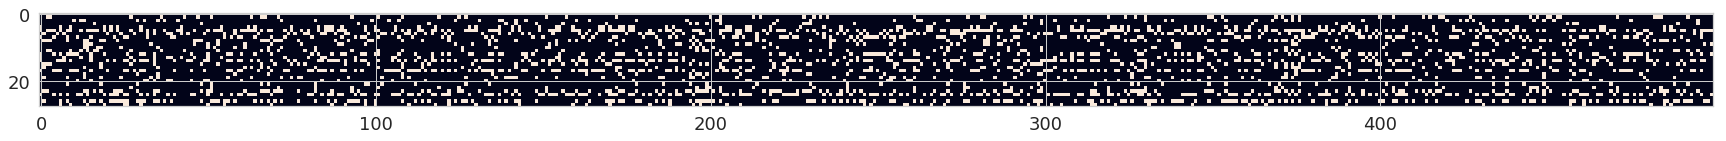

In [166]:
plt.figure(figsize=(30,4))
plt.imshow(supEmb[:500].T)

In [172]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

label_dict = {
    'embedding': supEmb, 
    'label_map': label_map,
    'cocoId': cocoId_arr, 
    'crop': crop_arr, 
    'cocoMap': cocoMap
    }

save_stuff(stim_root + "embedding_73K", flatten_dict(label_dict))

saved label_map.18 in h5py file
saved label_map.19 in h5py file
saved label_map.16 in h5py file
saved label_map.17 in h5py file
saved label_map.14 in h5py file
saved label_map.15 in h5py file
saved label_map.12 in h5py file
saved label_map.13 in h5py file
saved label_map.10 in h5py file
saved label_map.11 in h5py file
saved label_map.23 in h5py file
saved label_map.22 in h5py file
saved label_map.21 in h5py file
saved label_map.20 in h5py file
saved label_map.27 in h5py file
saved label_map.26 in h5py file
saved label_map.25 in h5py file
saved label_map.24 in h5py file
saved crop in h5py file
saved label_map.8 in h5py file
saved label_map.9 in h5py file
saved label_map.4 in h5py file
saved label_map.5 in h5py file
saved label_map.6 in h5py file
saved label_map.7 in h5py file
saved label_map.0 in h5py file
saved label_map.1 in h5py file
saved label_map.2 in h5py file
saved label_map.3 in h5py file
saved embedding in h5py file
saved cocoMap in h5py file
saved cocoId in h5py file


# Label maps for all subjects
This takes a long time since we need to load the image and annotations one-by-one and reinterpret them. 

In [ ]:
nx = 227
nc = len(super_nms)

for k in range(len(cocoId_arr)): # for all subjects
    l_image_data = np.zeros(shape=(len(cocoId_arr[k]), nx, nx), dtype=np.uint8)

    for i, (cId, crop) in tqdm(enumerate(zip(cocoId_arr[k], nsdcrop_arr[k]))):
        png_name = imgDir + '%012d.png' % cId
        img = skimage.io.imread(png_name)

        croppedImg = applyCropToImg(img, crop)
        croppedImg = (resize(croppedImg, (nx, nx), order=0) * 255.).astype('uint8')
        l_image_data[i,...] = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
        
    print l_image_data.shape
    save_stuff("%sS%d_supercategory_%d"%(stim_root, k+1, nx), flatten_dict({'labels': l_image_data, 'label_map': label_map, 'label_count': nc}))


0it [00:00, ?it/s]
11it [00:00, 103.60it/s]
22it [00:00, 103.48it/s]
33it [00:00, 104.90it/s]
44it [00:00, 105.48it/s]
56it [00:00, 109.04it/s]
68it [00:00, 111.73it/s]
79it [00:00, 111.09it/s]
91it [00:00, 112.49it/s]
102it [00:00, 105.80it/s]
113it [00:01, 103.80it/s]
124it [00:01, 103.72it/s]
135it [00:01, 101.87it/s]
148it [00:01, 107.54it/s]
159it [00:01, 104.98it/s]
171it [00:01, 106.86it/s]
183it [00:01, 108.16it/s]
195it [00:01, 111.23it/s]
207it [00:01, 113.20it/s]
219it [00:02, 111.39it/s]
231it [00:02, 113.83it/s]
243it [00:02, 111.94it/s]
255it [00:02, 103.34it/s]
266it [00:02, 98.80it/s] 
277it [00:02, 100.37it/s]
289it [00:02, 103.94it/s]
302it [00:02, 107.99it/s]
313it [00:02, 107.63it/s]
324it [00:03, 99.88it/s] 
335it [00:03, 98.72it/s]
346it [00:03, 100.39it/s]
357it [00:03, 100.52it/s]
369it [00:03, 104.96it/s]
380it [00:03, 103.20it/s]
391it [00:03, 100.97it/s]
402it [00:03, 98.35it/s] 
413it [00:03, 101.02it/s]
424it [00:04, 101.71it/s]
435it [00:04, 103.02it/s]
4

3251it [00:29, 107.57it/s]
3263it [00:29, 110.78it/s]
3275it [00:30, 108.63it/s]
3288it [00:30, 112.90it/s]
3300it [00:30, 108.91it/s]
3312it [00:30, 111.21it/s]
3324it [00:30, 110.94it/s]
3336it [00:30, 112.05it/s]
3348it [00:30, 111.27it/s]
3361it [00:30, 115.26it/s]
3373it [00:30, 116.63it/s]
3385it [00:31, 117.23it/s]
3397it [00:31, 117.89it/s]
3410it [00:31, 120.77it/s]
3423it [00:31, 118.65it/s]
3436it [00:31, 119.70it/s]
3448it [00:31, 114.40it/s]
3460it [00:31, 114.19it/s]
3472it [00:31, 111.51it/s]
3484it [00:31, 111.31it/s]
3496it [00:32, 111.22it/s]
3508it [00:32, 108.51it/s]
3520it [00:32, 109.22it/s]
3531it [00:32, 106.31it/s]
3543it [00:32, 108.13it/s]
3554it [00:32, 106.05it/s]
3566it [00:32, 107.95it/s]
3578it [00:32, 108.92it/s]
3591it [00:32, 112.36it/s]
3603it [00:32, 112.79it/s]
3616it [00:33, 116.87it/s]
3628it [00:33, 116.97it/s]
3640it [00:33, 117.18it/s]
3652it [00:33, 112.83it/s]
3664it [00:33, 110.40it/s]
3676it [00:33, 106.25it/s]
3689it [00:33, 110.78it/s]
3